# NBA Player Career Longevity Prediction

### **Objectif** : Pr√©dire si un joueur NBA aura une carri√®re d'au moins 5 ans

#### **M√©trique cible** : Maximiser le recall (pour identifier un maximum de joueurs ayant effectivement une longue carri√®re)

In [89]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, classification_report, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import joblib
import mlflow
from datetime import datetime
#import shap

# Description des features

Ce dataset contient des statistiques de joueurs de basket-ball ainsi qu'une cible binaire permettant de pr√©dire la dur√©e de carri√®re (‚â• 5 ans ou < 5 ans).

## Champs

| Nom         | Description |
|-------------|-------------|
| **Name**    | Nom du joueur *(string)* |
| **GP**      | Nombre de matchs jou√©s *(Games Played)* *(int)* |
| **MIN**     | Minutes jou√©es par match *(MinutesPlayed)* *(float)* |
| **PTS**     | Points marqu√©s par match *(PointsPerGame)* *(float)* |
| **FGM**     | Nombre de tirs r√©ussis *(FieldGoalsMade)* *(float)* |
| **FGA**     | Nombre de tirs tent√©s *(FieldGoalAttempts)* *(float)* |
| **FG%**     | Pourcentage de r√©ussite au tir *(FieldGoalPercent)* *(float)* |
| **3P Made** | Tirs √† 3 points r√©ussis *(3PointMade)* *(float)* |
| **3PA**     | Tirs √† 3 points tent√©s *(3PointAttempts)* *(float)* |
| **3P%**     | Pourcentage de r√©ussite √† 3 points *(3PointPercent)* *(float)* |
| **FTM**     | Lancers francs r√©ussis *(FreeThrowMade)* *(float)* |
| **FTA**     | Lancers francs tent√©s *(FreeThrowAttempts)* *(float)* |
| **FT%**     | Pourcentage de r√©ussite aux lancers francs *(FreeThrowPercent)* *(float)* |
| **OREB**    | Rebonds offensifs *(OffensiveRebounds)* *(float)* |
| **DREB**    | Rebonds d√©fensifs *(DefensiveRebounds)* *(float)* |
| **REB**     | Total des rebonds *(Rebounds)* *(float)* |
| **AST**     | Passes d√©cisives *(Assists)* *(float)* |
| **STL**     | Interceptions *(Steals)* *(float)* |
| **BLK**     | Contres *(Blocks)* *(float)* |
| **TOV**     | Balles perdues *(Turnovers)* *(float)* |
| **TARGET_5Yrs** | Variable cible : `1` si carri√®re ‚â• 5 ans, `0` si < 5 ans *(int)* |


In [90]:
df = pd.read_csv(".\\nba_logreg.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

- Toutes nos features seront donc num√©riques 

In [4]:
df.describe()

GP          MIN          PTS          FGM          FGA  \
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000   
mean     60.414179    17.624627     6.801493     2.629104     5.885299   
std      17.433992     8.307964     4.357545     1.683555     3.593488   
min      11.000000     3.100000     0.700000     0.300000     0.800000   
25%      47.000000    10.875000     3.700000     1.400000     3.300000   
50%      63.000000    16.100000     5.550000     2.100000     4.800000   
75%      77.000000    22.900000     8.800000     3.400000     7.500000   
max      82.000000    40.900000    28.200000    10.200000    19.800000   

               FG%      3P Made          3PA          3P%          FTM  \
count  1340.000000  1340.000000  1340.000000  1329.000000  1340.000000   
mean     44.169403     0.247612     0.779179    19.308126     1.297687   
std       6.137679     0.383688     1.061847    16.022916     0.987246   
min      23.800000     0.000000     0.000000     0.000000     0.000000   
25%      40.200000     0.000000     0.000000     0.000000     0.600000   
50%      44.100000     0.100000     0.300000    22.400000     1.000000   
75%      47.900000     0.400000     1.200000    32.500000     1.600000   
max      73.700000     2.300000     6.500000   100.000000     7.700000   

               FTA          FT%         OREB         DREB          REB  \
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000   
mean      1.821940    70.300299     1.009403     2.025746     3.034478   
std       1.322984    10.578479     0.777119     1.360008     2.057774   
min       0.000000     0.000000     0.000000     0.200000     0.300000   
25%       0.900000    64.700000     0.400000     1.000000     1.500000   
50%       1.500000    71.250000     0.800000     1.700000     2.500000   
75%       2.300000    77.600000     1.400000     2.600000     4.000000   
max      10.200000   100.000000     5.300000     9.600000    13.900000   

               AST          STL          BLK          TOV  TARGET_5Yrs  
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000  
mean      1.550522     0.618507     0.368582     1.193582     0.620149  
std       1.471169     0.409759     0.429049     0.722541     0.485531  
min       0.000000     0.000000     0.000000     0.100000     0.000000  
25%       0.600000     0.300000     0.100000     0.700000     0.000000  
50%       1.100000     0.500000     0.200000     1.000000     1.000000  
75%       2.000000     0.800000     0.500000     1.500000     1.000000  
max      10.600000     2.500000     3.900000     4.400000     1.000000

In [5]:
df.head()

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  ...  \
0   Brandon Ingram  36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0  ...   
1  Andrew Harrison  35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5  ...   
2   JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4  ...   
3      Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6  ...   
4      Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0  ...   

   FTA   FT%  OREB  DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0  2.3  69.9   0.7   3.4  4.1  1.9  0.4  0.4  1.3          0.0  
1  3.4  76.5   0.5   2.0  2.4  3.7  1.1  0.5  1.6          0.0  
2  1.3  67.0   0.5   1.7  2.2  1.0  0.5  0.3  1.0          0.0  
3  1.3  68.9   1.0   0.9  1.9  0.8  0.6  0.1  1.0          1.0  
4  1.9  67.4   1.0   1.5  2.5  0.3  0.3  0.4  0.8          1.0  

[5 rows x 21 columns]

## Observation

Colonnes comme `REB`, `OREB`, `DREB`, `3P Made`, `3PA`, etc. contiennent des **floats**, indiquant qu'il s'agit probablement de **moyennes par match** plut√¥t que de totaux.


In [6]:
df.isna().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

- Remplacer les NaN par 0 quand 3PA = 0 car un joueur qui ne tente pas de 3P a une r√©ussite de 0% (pas de division par 0)

In [7]:
# Caster la target en int
df['TARGET_5Yrs'] = df['TARGET_5Yrs'].astype(int)

In [8]:
df[df['3P%'].isna()][['Name', 'GP', '3P Made', '3PA', '3P%']]


Name  GP  3P Made  3PA  3P%
338     Ken Johnson  64      0.0  0.0  NaN
339     Ken Johnson  64      0.0  0.0  NaN
340   Pete Williams  53      0.0  0.0  NaN
358   Melvin Turpin  79      0.0  0.0  NaN
386    Jim Petersen  60      0.0  0.0  NaN
397   Tom Scheffler  39      0.0  0.0  NaN
507    Sam Williams  59      0.0  0.0  NaN
509   Kurt Nimphius  63      0.0  0.0  NaN
510  Pete Verhoeven  71      0.0  0.0  NaN
521       Jim Smith  72      0.0  0.0  NaN
559    Jeff Wilkins  56      0.0  0.0  NaN

In [9]:
# Remplacer uniquement les NaN qui correspondent √† 0 tentatives
mask = df['3P%'].isna() & (df['3PA'] == 0)
df.loc[mask, '3P%'] = 0.0

In [10]:
# Colonnes pourcentages
percent_cols = ['FG%', '3P%', 'FT%']

# Valeurs hors de 0‚Äì100
for col in percent_cols:
    outliers = df[(df[col] < 0) | (df[col] > 100)]
    if not outliers.empty:
        print(f"Outliers dans {col}:")
        print(outliers[['Name', col]])


In [11]:
for i in percent_cols :
    print(f"{i} max : {df[i].max()} & min : {df[i].min()}")

FG% max : 73.7 & min : 23.8
3P% max : 100.0 & min : 0.0
FT% max : 100.0 & min : 0.0


In [12]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


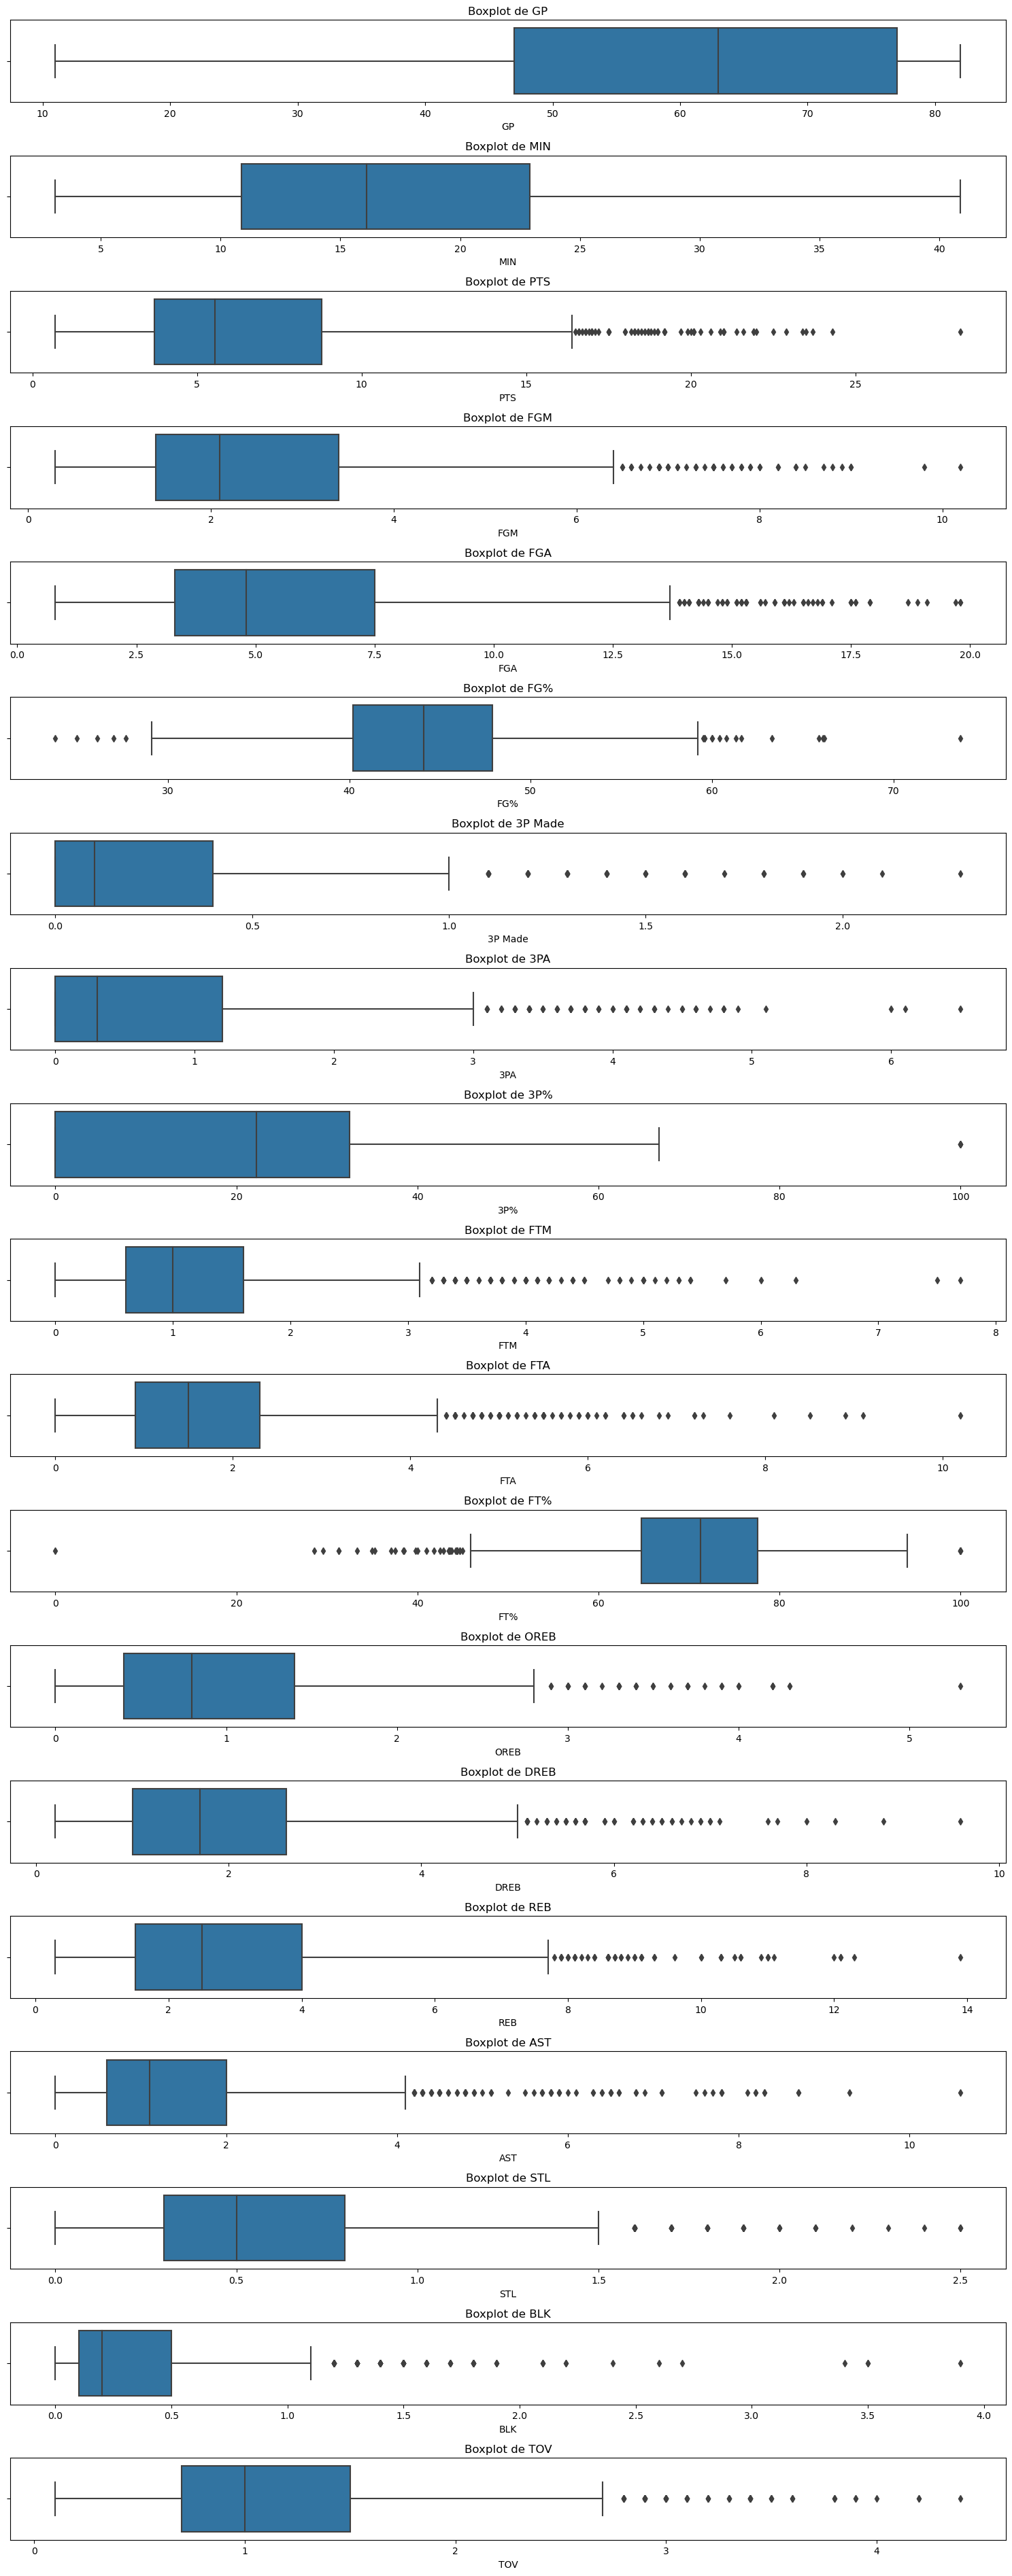

In [13]:


# Graphiques en bougie pour chaque variable
plt.figure(figsize=(15, len(numeric_cols) * 2))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], orient='h')
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


### Boxplot : on voit une distribution asym√©trique avec des outliers (superstars)


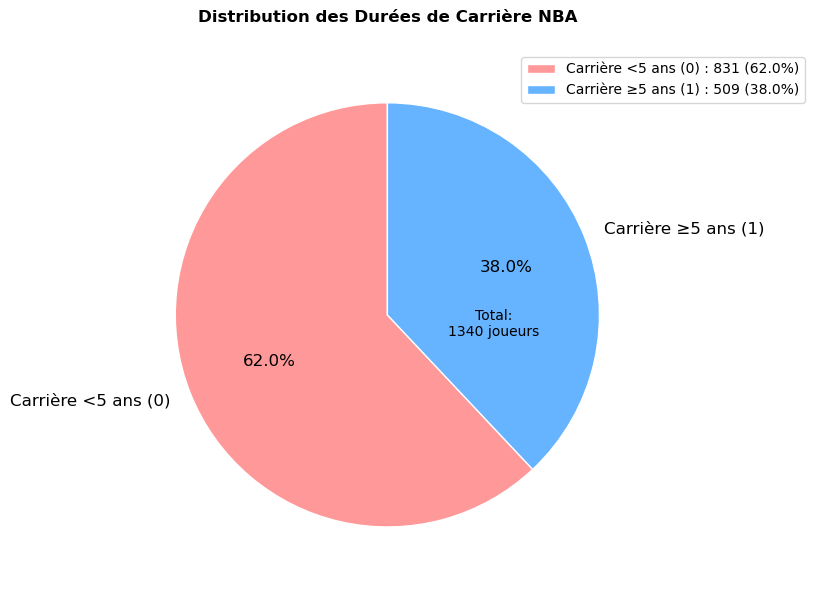

In [92]:
# Distribution de la variable cible TARGET_5Yrs (camembert + comptage)
target_counts = df['TARGET_5Yrs'].value_counts()
labels = ['Carri√®re <5 ans (0)', 'Carri√®re ‚â•5 ans (1)']
colors = ['#ff9999', '#66b3ff']  # Rouge pour <5 ans, Bleu pour ‚â•5 ans

plt.figure(figsize=(8, 6))
plt.pie(
    target_counts, 
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 12}
)

# Ajout du titre et annotation du nombre absolu
plt.title('Distribution des Dur√©es de Carri√®re NBA', pad=20, fontweight='bold')
plt.annotate(
    f"Total:\n{target_counts.sum()} joueurs", 
    xy=(0.5, -0.1), 
    ha='center',
    fontsize=10
)

# Affichage des valeurs absolues dans le pie
plt.legend(
    [f"{label} : {count} ({pct:.1f}%)" for label, count, pct in zip(
        labels, 
        target_counts, 
        target_counts/target_counts.sum()*100
    )],
    loc="upper right",
    bbox_to_anchor=(1.3, 1)
)

plt.tight_layout()
plt.show()

### On voit qu'on a une r√©partition in√©gale avec pr√®s de deux tiers en carri√®re longue

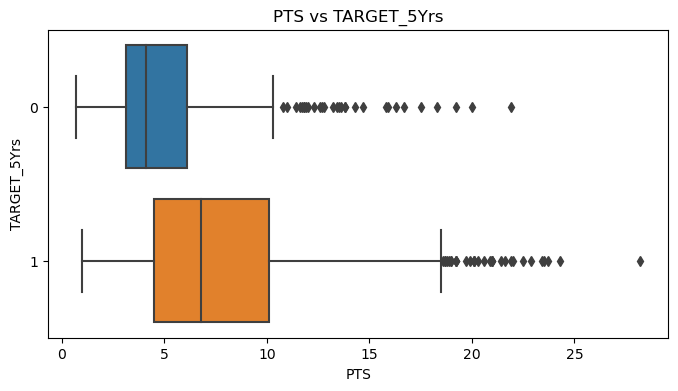

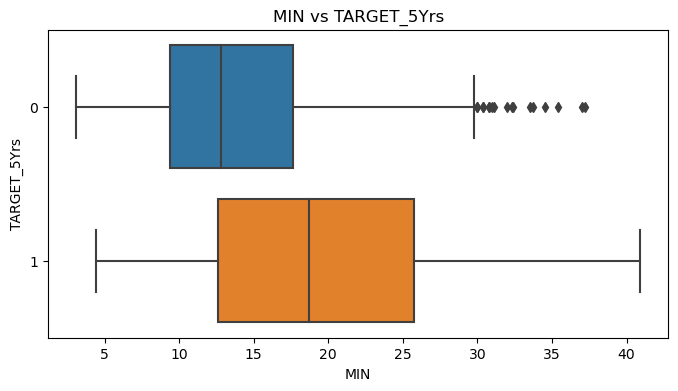

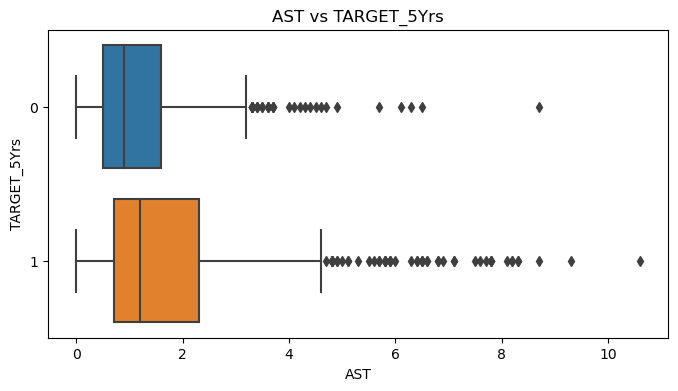

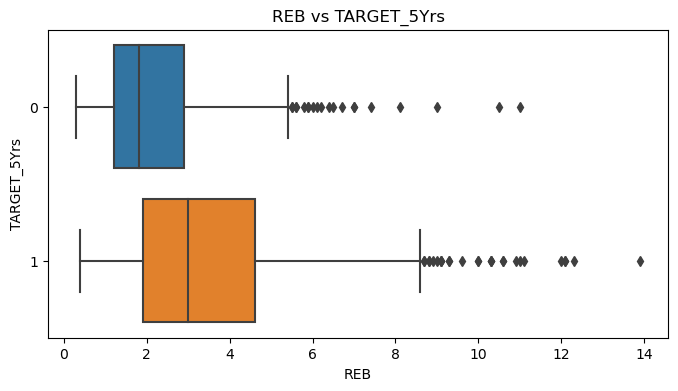

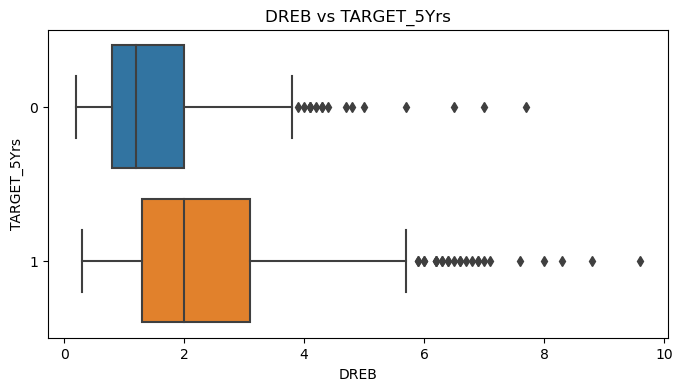

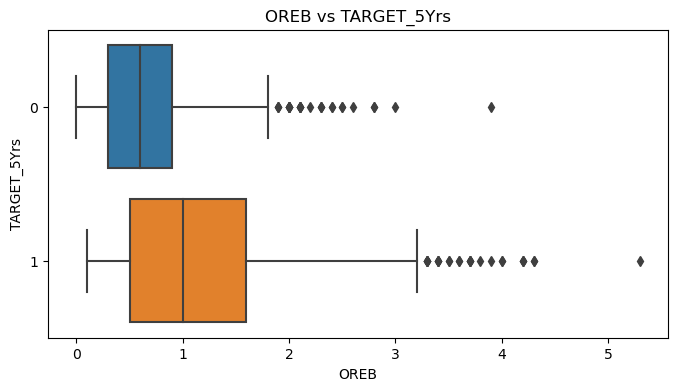

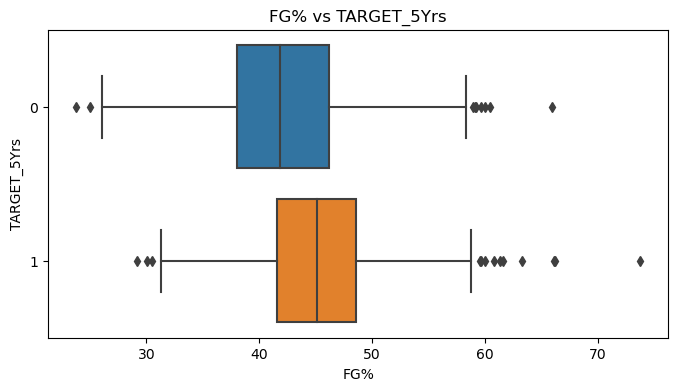

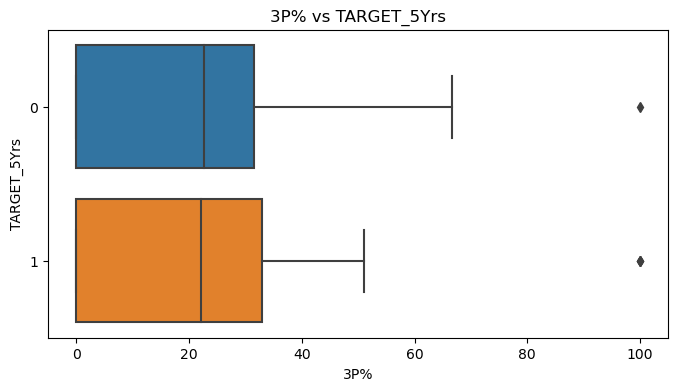

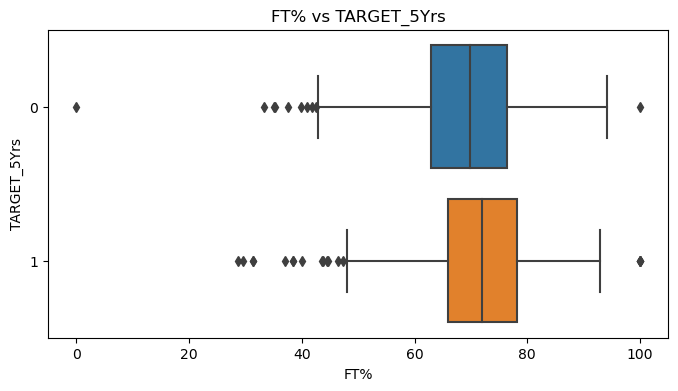

In [15]:
# Visualisation des relations features vs cible (boxplots horizontaux)
features_to_plot = ['PTS', 'MIN', 'AST', 'REB','DREB','OREB', 'FG%', '3P%', 'FT%']  # √† adapter selon ton dataset

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.boxplot(y='TARGET_5Yrs', x=feature, data=df, orient='h')
    plt.title(f'{feature} vs TARGET_5Yrs')
    plt.show()


### dans l'ensemble, on voit que les joueurs peu importe leur long√©vit√© ont a peu pr√®s le m√™me range de performance, il y a des donn√©es non dispoonibles qui peuvent l'expliquer : blessures, situation personnelles, age, poste, etc ...

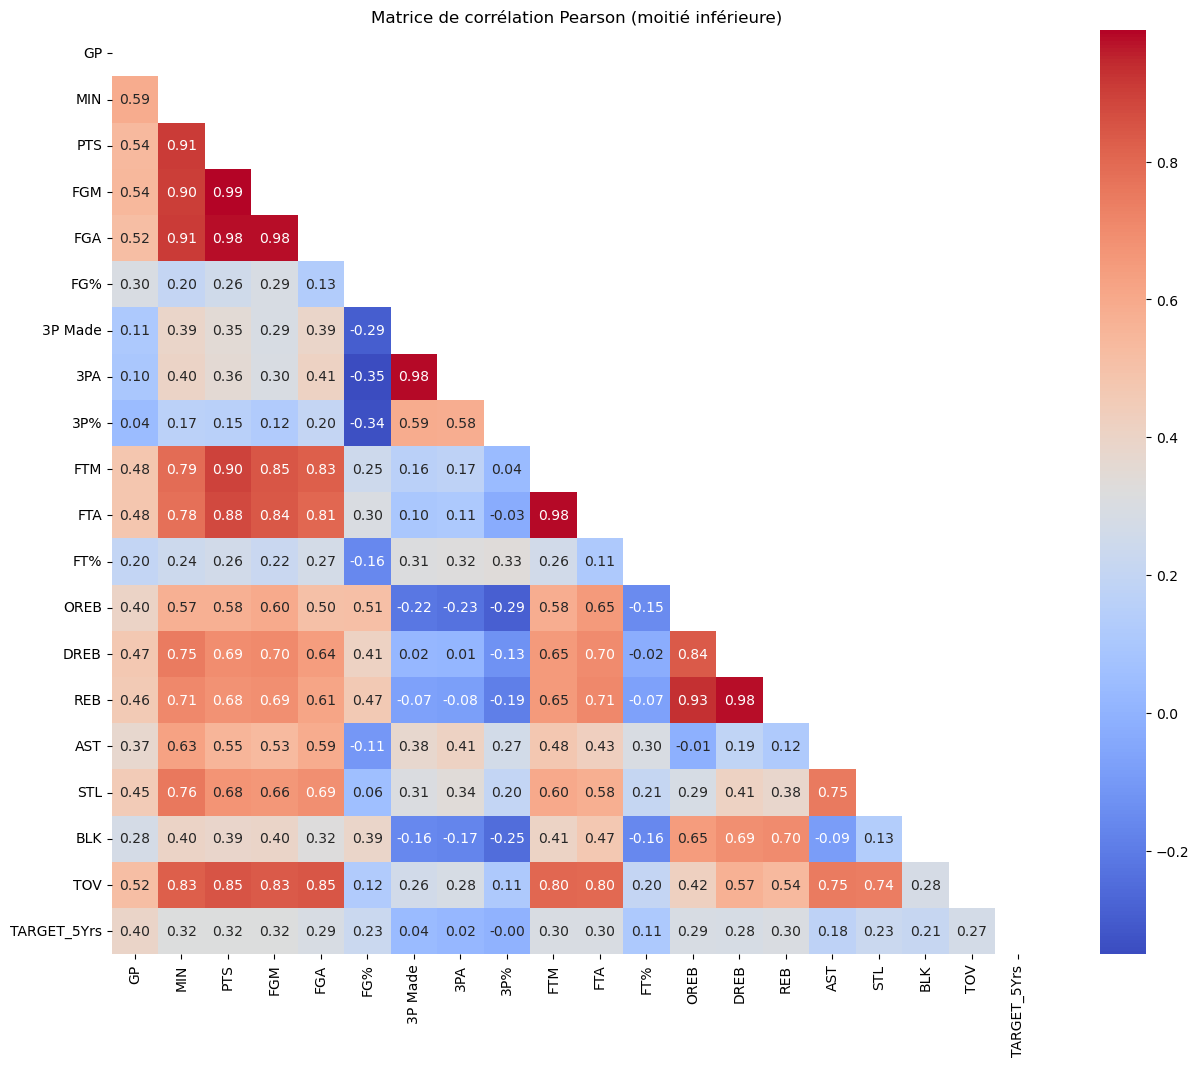

In [16]:
# calcul de la matrice de corr√©lation (Pearson par d√©faut)
corr_matrix_pearson = df.corr()


plt.figure(figsize=(15,12))
mask = np.triu(np.ones_like(corr_matrix_pearson, dtype=bool))  # masque la moiti√© sup√©rieure
sns.heatmap(corr_matrix_pearson, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corr√©lation Pearson (moiti√© inf√©rieure)')
plt.show()


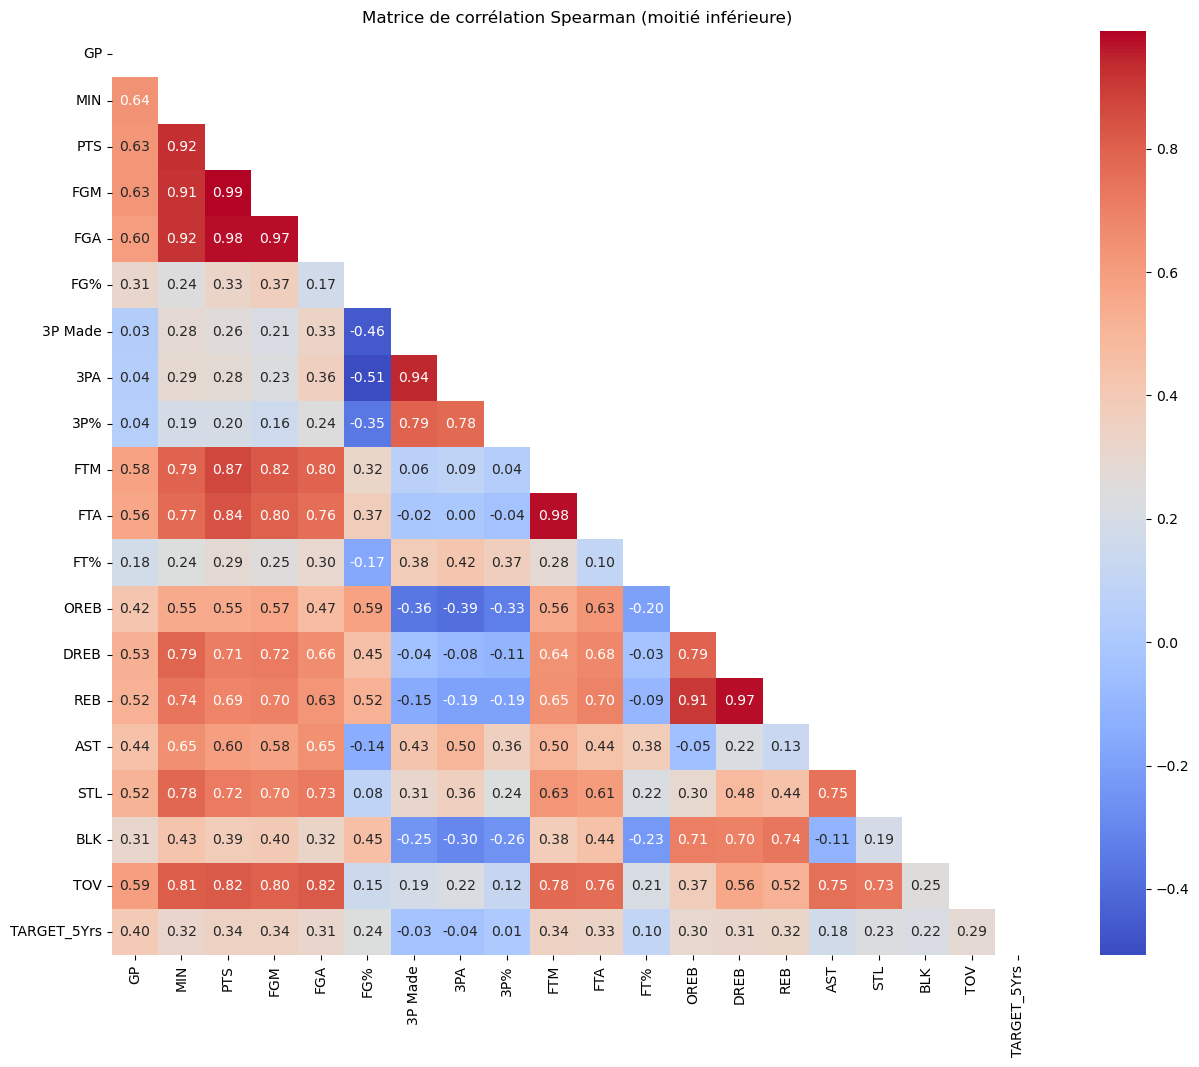

In [17]:
# calcul de la matrice de corr√©lation Spearman (inclut la target)
corr_matrix_spearman = df.corr(method='spearman')

# affichage avec heatmap
plt.figure(figsize=(15,12))
mask = np.triu(np.ones_like(corr_matrix_spearman, dtype=bool))  # masque moiti√© sup√©rieure
sns.heatmap(corr_matrix_spearman, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corr√©lation Spearman (moiti√© inf√©rieure)')
plt.show()

In [18]:
# seuil de corr√©lation pour consid√©rer une redondance
seuil = 0.90

def get_high_corr_pairs(corr_matrix, seuil=0.85):
    corr_matrix_abs = corr_matrix.abs()
    # Masque la diagonale et la moiti√© sup√©rieure
    mask = np.triu(np.ones_like(corr_matrix_abs, dtype=bool))
    corr_matrix_masked = corr_matrix_abs.mask(mask)
    
    # Trouver toutes les paires sup√©rieures au seuil
    high_corr = corr_matrix_masked.stack()
    high_corr = high_corr[high_corr > seuil].sort_values(ascending=False)
    return high_corr

# Spearman
high_corr_spearman = get_high_corr_pairs(corr_matrix_spearman, seuil)
print("Paires de features fortement corr√©l√©es (Spearman) :")
print(high_corr_spearman)

# Pearson
high_corr_pearson = get_high_corr_pairs(corr_matrix_pearson, seuil)
print("\nPaires de features fortement corr√©l√©es (Pearson) :")
print(high_corr_pearson)


Paires de features fortement corr√©l√©es (Spearman) :
FGM  PTS        0.990493
FGA  PTS        0.975944
FTA  FTM        0.975564
FGA  FGM        0.974310
REB  DREB       0.973636
3PA  3P Made    0.939316
PTS  MIN        0.924537
FGA  MIN        0.916515
FGM  MIN        0.914580
REB  OREB       0.905563
dtype: float64

Paires de features fortement corr√©l√©es (Pearson) :
FGM  PTS        0.990834
3PA  3P Made    0.982616
FTA  FTM        0.980505
FGA  FGM        0.980050
     PTS        0.979733
REB  DREB       0.978177
     OREB       0.932694
PTS  MIN        0.911822
FGA  MIN        0.910247
FGM  MIN        0.903060
dtype: float64


In [19]:
corr_matrix_spearman["TARGET_5Yrs"]

GP             0.396913
MIN            0.317360
PTS            0.344736
FGM            0.344800
FGA            0.307072
FG%            0.239037
3P Made       -0.031888
3PA           -0.038425
3P%            0.006878
FTM            0.341028
FTA            0.330763
FT%            0.102149
OREB           0.304435
DREB           0.306155
REB            0.320500
AST            0.176212
STL            0.232763
BLK            0.217504
TOV            0.285391
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

In [20]:
corr_matrix_pearson["TARGET_5Yrs"]

GP             0.396833
MIN            0.317805
PTS            0.315981
FGM            0.317594
FGA            0.292660
FG%            0.227134
3P Made        0.036619
3PA            0.018110
3P%           -0.000004
FTM            0.296841
FTA            0.296089
FT%            0.106706
OREB           0.293307
DREB           0.284677
REB            0.299406
AST            0.175353
STL            0.229811
BLK            0.210114
TOV            0.272348
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

# Analyse des corr√©lations et s√©lection de features

## 1Ô∏è‚É£ Analyse des corr√©lations avec la target

### Variables mod√©r√©ment corr√©l√©es (0.3‚Äì0.4)
- **Features informatives** :  
  `GP`, `PTS`, `FGM`, `FGA`, `FTM`, `FTA`, `MIN`, `REB`  
  ‚Üí *Ces variables expliquent le mieux la target*.

### Variables faiblement corr√©l√©es (<0.2)
- **Peu contributives** :  
  `AST`, `STL`, `BLK`, `FT%`  
  ‚Üí *Impact limit√© sur la target*.

### Variables non corr√©l√©es/n√©gatives
- **Sans impact direct** :  
  `3PA`, `3P Made`, `3P%`  
  ‚Üí *Peu utiles pour pr√©dire la target*.

---

## 2Ô∏è‚É£ Analyse des paires fortement corr√©l√©es

### Groupes redondants
| Variables              | Action recommand√©e                          |
|------------------------|--------------------------------------------|
| `FGM`, `FGA`, `PTS`, `MIN` | Garder **`PTS`** ou **`MIN + PTS`**       |
| `FTA`, `FTM`           | Combiner en **`FT_impact = FTM * FT%`**    |
| `REB`, `DREB`, `OREB`  | Garder **`REB`** + ratio **`OREB/REB`**    |
| `3PA`, `3P Made`       | Garder **`3P%`** (efficacit√©) ou **`3P Made`** (volume) |

---

## 3Ô∏è‚É£ Proposition de features finales

| Feature originale | Action / Transformation               | Raison                                                                 |
|-------------------|---------------------------------------|-----------------------------------------------------------------------|
| **`PTS`**         | Garder                                | Corr√©lation forte avec la target (scoring total)                      |
| **`MIN`**         | Optionnelle                           | Utile pour normaliser l'efficacit√©                                    |
| **`FGM`**, `FGA`  | Supprimer ou combiner                 | Redondantes avec `PTS`                                                |
| **`FTM`**, `FTA`  | Cr√©er **`FT_impact = FTM * FT%`**     | Combine volume et efficacit√©                                          |
| **`3P`**-related  | Cr√©er **`3P_impact = 3P Made * 3P%`** | Capture √† la fois le volume et la pr√©cision                           |
| **`REB`**         | Garder + ratio **`OREB/REB`**         | R√©duit la multicolin√©arit√© et conserve l'info offensive               |
| **`AST`**, `STL`, `BLK`, `TOV` | Garder si pertinent           | Peu corr√©l√©es √† la target, mais potentiellement utiles pour certains mod√®les |

### Notes suppl√©mentaires
- **`FT%`** : Devenue optionnelle si int√©gr√©e dans `FT_impact`.
- **Mod√®les complexes** (Random Forest, SVM) : Les features faiblement corr√©l√©es (`AST`, `STL`) peuvent apporter un signal compl√©mentaire.

# Plan de s√©lection et transformation des features

## 1Ô∏è‚É£ Colonnes √† conserver sans modification

| Feature | Justification |
|---------|---------------|
| **`PTS`** | Capture le scoring total (forte corr√©lation avec la target) |
| **`REB`** | Synth√©tise les rebonds totaux (remplace `DREB` + `OREB`) |
| **`AST`** | Signal compl√©mentaire malgr√© faible corr√©lation (passe d√©cisive) |
| **`STL`** | Information d√©fensive (interceptions) |
| **`BLK`** | Information d√©fensive (contres) |
| **`TOV`** | Indicateur d'efficacit√© globale (pertes de balle) |
| **`MIN`** | *(Optionnel)* Permet de normaliser d'autres stats par minute |

## 2Ô∏è‚É£ Colonnes √† supprimer (redondances)

- `FGM`, `FGA` ‚Üí D√©j√† encapsul√©es dans **`PTS`**
- `DREB`, `OREB` ‚Üí Remplac√©es par **`REB`**
- `FTA` ‚Üí Redondante avec `FTM`
- `3PA` ‚Üí Redondante avec `3P Made` ou `3P%`

## 3Ô∏è‚É£ Colonnes √† transformer/combiner

### Transformations propos√©es

| Features d'origine | Nouvelle feature | Formule | Avantage |
|--------------------|------------------|---------|----------|
| `FTM` + `FT%` | **`FT_impact`** | `FTM * FT%` | Combine volume et efficacit√© au lancer-franc |
| `3P Made` + `3P%` | **`3P_impact`** | `3P Made * 3P%` | Mesure combin√©e de volume et pr√©cision √† 3-points |

üí° **Option** :  
- Conserver uniquement **`3P%`** pour l'efficacit√© pure  
- Ou **`3P Made`** pour le volume seul  
- *(Recommand√© : `3P_impact` pour une vision synth√©tique)*

---


In [21]:

# --- Cr√©ation des colonnes combin√©es ---
# Free Throw impact : volume * efficacit√©
#df['FT_impact'] = df['FTM'] * df['FT%']

# 3-Point impact : volume * efficacit√©
#df['3P_impact'] = df['3P Made'] * df['3P%']

# --- Colonnes √† drop ---
#cols_to_drop = ['FGM', 'FGA', 'DREB', 'OREB', 'FTA', '3PA', 'FTM', '3P Made', '3P%']

#df_clean = df.drop(columns=cols_to_drop)


In [22]:
# --- Colonnes combin√©es d√©j√† cr√©√©es ---
# Free Throw impact : volume * efficacit√©
df['FT_impact'] = df['FTM'] * df['FT%']

# 3-Point impact : volume * efficacit√©
df['3P_impact'] = df['3P Made'] * df['3P%']

# --- Colonnes totales ---
#df['Minutes_totales'] = df['GP'] * df['MIN']
#df['Points_totales'] = df['PTS'] * df['GP']

# --- Ratios par minute ---
#df['Points_per_min'] = df['PTS'] / df['MIN']
#df['3P_per_min'] = df['3P Made'] / df['MIN']
#df['Rebounds_per_min'] = df['REB'] / df['MIN']
#df['Assists_per_min'] = df['AST'] / df['MIN']
#df['Steals_per_min'] = df['STL'] / df['MIN']
#df['Blocks_per_min'] = df['BLK'] / df['MIN']
#df['Turnovers_per_min'] = df['TOV'] / df['MIN']

# --- Ratios d'efficacit√© ---
#df['Shooting_efficiency'] = df['FGM'] / df['FGA']

# --- Colonnes √† drop ---
cols_to_drop = [
    'FGM', 'FGA', 'DREB', 'OREB', 'FTA', '3PA', 'FTM', '3P Made', '3P%'
]

df_clean = df.drop(columns=cols_to_drop)



#### En ayant fait plusieurs essais de features engineering, plus les colonnes √©taient nombreuses et moins parfois les mod√®les avait de bons scores, j'ai donc pris en compte cela et adapt√© le nombre de colonne avec le nombre de lignes de mani√®re a ce que ce soit coh√©rent pour les mod√®les et √©viter les overfitting ou underfitting

In [23]:
df_clean.head()

Name  GP   MIN  PTS   FG%   FT%  REB  AST  STL  BLK  TOV  \
0   Brandon Ingram  36  27.4  7.4  34.7  69.9  4.1  1.9  0.4  0.4  1.3   
1  Andrew Harrison  35  26.9  7.2  29.6  76.5  2.4  3.7  1.1  0.5  1.6   
2   JaKarr Sampson  74  15.3  5.2  42.2  67.0  2.2  1.0  0.5  0.3  1.0   
3      Malik Sealy  58  11.6  5.7  42.6  68.9  1.9  0.8  0.6  0.1  1.0   
4      Matt Geiger  48  11.5  4.5  52.4  67.4  2.5  0.3  0.3  0.4  0.8   

   TARGET_5Yrs  FT_impact  3P_impact  
0            0     111.84      12.50  
1            0     198.90      16.45  
2            0      60.30       9.76  
3            1      62.01       2.26  
4            1      87.62       0.00

In [24]:
print(df_clean.isna().sum())  # Si c'est un DataFrame

# S√©lection des colonnes num√©riques uniquement
num_cols = df_clean.select_dtypes(include=np.number).columns

# V√©rification des infinis
print(np.isinf(df_clean[num_cols]).sum())


Name           0
GP             0
MIN            0
PTS            0
FG%            0
FT%            0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
FT_impact      0
3P_impact      0
dtype: int64
GP             0
MIN            0
PTS            0
FG%            0
FT%            0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
FT_impact      0
3P_impact      0
dtype: int64


In [25]:
# On v√©rifie les types pcq les float 64 ca passe mais 128 bits peut faire faire bugger les mod√®les
pd.DataFrame(df_clean.dtypes, columns=['Type'])


Type
Name          object
GP             int64
MIN          float64
PTS          float64
FG%          float64
FT%          float64
REB          float64
AST          float64
STL          float64
BLK          float64
TOV          float64
TARGET_5Yrs    int32
FT_impact    float64
3P_impact    float64

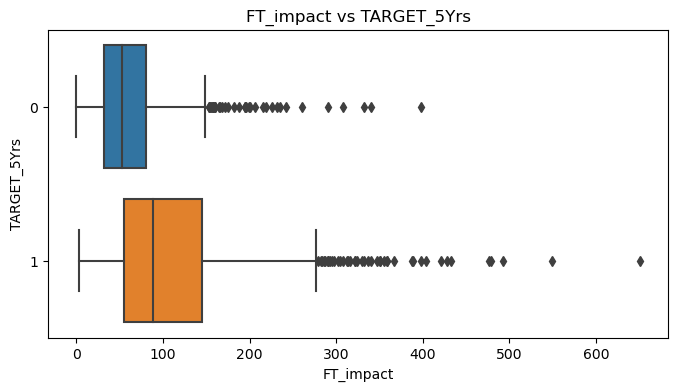

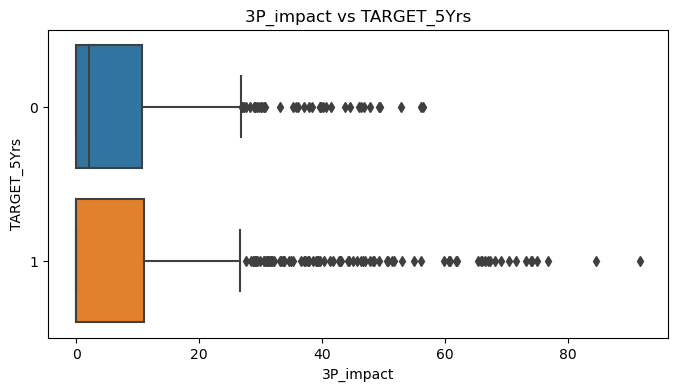

In [26]:
# Visualisation des relations features vs cible (boxplots horizontaux)
features_to_plot = ['FT_impact', '3P_impact']  # √† adapter selon ton dataset

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.boxplot(y='TARGET_5Yrs', x=feature, data=df_clean, orient='h')
    plt.title(f'{feature} vs TARGET_5Yrs')
    plt.show()


#### On peut voir que pour les carrieres longues, la m√©diane est confondue avec le quantile : les colonnes produites qui montrent l'impact direct montre ici une difference m√™me si on voit bcp d'individus performants avec des carrieres courtes 

In [29]:

def prepare_scaled_data(df, target_col, cols_to_scale, test_size=0.2, random_state=42):
    """
    S√©pare le dataset en train/test et standardise les colonnes num√©riques sp√©cifi√©es.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataset complet.
    target_col : str
        Nom de la colonne cible.
    cols_to_scale : list
        Liste des colonnes √† standardiser.
    test_size : float, default=0.2
        Proportion du test set.
    random_state : int, default=42
        Pour reproductibilit√©.
    
    Returns
    -------
    X_train_scaled : pd.DataFrame
        Features standardis√©es pour l'entra√Ænement.
    X_test_scaled : pd.DataFrame
        Features standardis√©es pour le test.
    y_train : pd.Series
        Labels d'entra√Ænement.
    y_test : pd.Series
        Labels de test.
    scaler : StandardScaler
        Objet scaler (utile si besoin de transformer de nouvelles donn√©es).
    """
    
    # S√©paration des features et labels
    X = df[cols_to_scale]
    y = df[target_col]
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=cols_to_scale,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=cols_to_scale,
        index=X_test.index
    )
    
    print("Dataset pr√™t pour l'entra√Ænement :")
    print("X_train shape:", X_train_scaled.shape)
    print("X_test shape:", X_test_scaled.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


In [96]:
#on selectionne les colonnes num√©riques pour scaler : centre et r√©duit 
# en gros on soustrait la moyenne puis on divise par ecart type
# cela permet de baisser les dimensions pour les calculs lin√©aire comme la r√©gression 


cols_standard = df_clean.select_dtypes(include='number').columns.drop('TARGET_5Yrs')
print(cols_standard)

Index(['GP', 'MIN', 'PTS', 'FG%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'FT_impact', '3P_impact'],
      dtype='object')


In [31]:

X_train_scaled, X_test_scaled, y_train, y_test, scaler_std = prepare_scaled_data(
    df_clean, target_col='TARGET_5Yrs', cols_to_scale=cols_standard
)


Dataset pr√™t pour l'entra√Ænement :
X_train shape: (1072, 12)
X_test shape: (268, 12)
y_train shape: (1072,)
y_test shape: (268,)


In [97]:
X_test_scaled.describe()
# on devrait voir des moyenne = 0 et des ecart type std = 1 (environ)

GP         MIN         PTS         FG%         FT%         REB  \
count  268.000000  268.000000  268.000000  268.000000  268.000000  268.000000   
mean     0.071132    0.061353    0.049239    0.022154   -0.036889    0.099036   
std      0.976713    1.038789    1.031812    0.939368    0.986481    1.079254   
min     -2.751128   -1.616778   -1.353429   -2.421940   -3.307501   -1.232876   
25%     -0.652016   -0.806781   -0.706614   -0.602492   -0.617923   -0.689194   
50%      0.276163   -0.118133   -0.244603    0.001307    0.091597   -0.194936   
75%      0.961587    0.782874    0.523490    0.737942    0.704472    0.558806   
max      1.247180    2.836685    4.953019    2.682175    2.066939    4.500506   

              AST         STL         BLK         TOV   FT_impact   3P_impact  
count  268.000000  268.000000  268.000000  268.000000  268.000000  268.000000  
mean    -0.037749    0.018595    0.031836    0.016927    0.017289    0.025246  
std      0.985389    0.980036    1.014149    1.004219    1.094115    1.007876  
min     -0.990773   -1.256716   -0.855207   -1.511448   -1.117413   -0.588075  
25%     -0.651852   -0.770538   -0.621453   -0.680326   -0.684189   -0.588075  
50%     -0.346824   -0.162815   -0.387700   -0.264765   -0.277143   -0.588075  
75%      0.093772    0.444908    0.313561    0.427837    0.305309    0.304082  
max      5.245360    4.334334    7.092419    3.890845    7.439552    4.721708

# Randomized Search

In [35]:

# Param√®tres des mod√®les (pour RandomizedSearchCV, on peut utiliser des distributions)
#models_params = {
#    'RandomForest': {
#        'model': RandomForestClassifier(random_state=42),
#       'params': {
#            'n_estimators': randint(50, 201),
#            'max_depth': [None, 5, 10, 15],
#            'min_samples_split': randint(2, 11)
#        }
#    },
#    'XGBoost': {
 #       'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
  #      'params': {
#            'n_estimators': randint(50, 201),
#            'max_depth': randint(3, 8),
#            'learning_rate': uniform(0.01, 0.19)  # de 0.01 √† 0.2
#        }
#    },
#    'SVM': {
#        'model': SVC(probability=True, random_state=42),
#        'params': {
#            'C': uniform(0.1, 9.9),  # de 0.1 √† 10
#            'kernel': ['linear', 'rbf'],
#            'gamma': ['scale', 'auto']
#        }
#    },
#    'LogisticRegression': {
#        'model': LogisticRegression(max_iter=1000, random_state=42),
#        'params': {
#            'C': uniform(0.1, 9.9),
#            'penalty': ['l2'],
#            'solver': ['lbfgs']
#        }
#    }
#}
#
#model_scores = {}

# CV et scorer
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
#scorer = make_scorer(recall_score)

#best_models = {}

# Boucle sur les mod√®les
#for name, mp in models_params.items():
#    print(f"\nüîç RandomizedSearchCV pour {name}...")

#    random_search = RandomizedSearchCV(
#        mp['model'],
   #     mp['params'],
#        scoring=scorer,
#        cv=kf,
 #       n_iter=30,       # nombre de combinaisons al√©atoires √† tester
# #       n_jobs=-1,
 #       random_state=42
  #  )
    
 #   random_search.fit(X_train, y_train)
    
 #   best_models[name+"_recall_score_rs"] = random_search.best_estimator_
    
 #   # Pr√©dictions en CV sur train (pas de fuite)
 #   cv_preds = cross_val_predict(random_search.best_estimator_, X_train, y_train, cv=kf)
 #   
 #   recall = recall_score(y_train, cv_preds)
 #   precision = precision_score(y_train, cv_preds)
 #   accuracy = accuracy_score(y_train, cv_preds)
    
  #  model_scores[name+"_recall_score"] = {'recall': recall, 'precision': precision}
    
  #  print(f"Meilleur recall (CV) : {random_search.best_score_:.4f}")
  #  print(f"Meilleurs param√®tres : {random_search.best_params_}")
  #  print(f"Recall (CV) : {recall:.4f} | Precision (CV) : {precision:.4f} | Accuracy (CV) : {accuracy:.4f}")
  #  print("Confusion Matrix:")
  #  print(confusion_matrix(y_train, cv_preds))


In [36]:
# on stockera de mani√®re brouillone les metrics et param 
#dans ce dictionnaire 
# Les fonctions sont maj pour stocker √† pr√©sent sur MLFLOW , les infos des models
all_scoring_models = {}

In [98]:
#on utilise le randomized qui va choisir aleatoirement les parametre sur des
# modeles avec bcp de parametre et de combinaisons pour mieux choisir les
# params sur le gridsearch 

# le gridsearch fait tout les parametres proposer dans la grille mais 
#c'est long

# alors le grid search randomise les parametre et itere ce qui permet 
# de reduire le temps et de determiner a peu pres les parametre a tester 
# en gridsearch par la suite 
def run_randomized_search(models_params, X_train, y_train, scorer_name='precision', cv_folds=5, n_iter=20):
    """
    Ex√©cute un RandomizedSearchCV sur plusieurs mod√®les avec CV et retourne les meilleurs mod√®les et scores.
    
    Parameters
    ----------
    models_params : dict
        Dictionnaire contenant les mod√®les et leur param_grid.
    X_train : array-like
        Donn√©es d'entra√Ænement.
    y_train : array-like
        Labels d'entra√Ænement.
    scorer_name : str, default='precision'
        Choix du scorer ('precision', 'recall', 'accuracy').
    cv_folds : int, default=5
        Nombre de folds pour la cross-validation.
    n_iter : int, default=20
        Nombre d'it√©rations al√©atoires √† tester dans RandomizedSearchCV.
    
    Returns
    -------
    best_models : dict
        Mod√®les optimis√©s par RandomizedSearchCV.
    model_scores : dict
        Scores (recall, precision, accuracy) obtenus en CV sur train.
    """
    
    scorers = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': make_scorer(accuracy_score)
    }
    
    if scorer_name not in scorers:
        raise ValueError(f"scorer_name doit √™tre dans {list(scorers.keys())}")
    
    scorer = scorers[scorer_name]
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    best_models = {}
    model_scores = {}
    
    for name, mp in models_params.items():
        print(f"\n üîç RandomizedSearchCV pour {name}...")
        
        rand_search = RandomizedSearchCV(
            mp['model'],
            mp['params'],
            scoring=scorer,
            cv=kf,
            n_iter=n_iter,
            n_jobs=-1,
            random_state=42
        )
        rand_search.fit(X_train, y_train)
        
        
        # Pr√©dictions en CV sur train
        cv_preds = cross_val_predict(rand_search.best_estimator_, X_train, y_train, cv=kf)
        
        recall = recall_score(y_train, cv_preds)
        precision = precision_score(y_train, cv_preds)
        accuracy = accuracy_score(y_train, cv_preds)
        
        model_scores[name+"_best_"+scorer_name+"_rs"] = {'recall': recall, 'precision': precision, 'accuracy': accuracy , 'params':rand_search.best_estimator_.get_params()  ,'trained_estimator': rand_search.best_estimator_.__class__.__name__ }
        

        with mlflow.start_run(run_name=name+"_best_"+scorer_name+f"rs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
            # log hyperparams
            mlflow.log_params(rand_search.best_params_)
            # log metrics
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("accuracy", accuracy)
            # log le nom du mod√®le
            mlflow.log_param("model", rand_search.best_estimator_.__class__.__name__)
            # log l‚Äôartefact
            mlflow.sklearn.log_model(rand_search.best_estimator_, "model")
        
        print(f"Meilleur {scorer_name} (CV) : {rand_search.best_score_:.4f}")
        print(f"Meilleurs param√®tres : {rand_search.best_params_}")
        print(f"Recall (CV) : {recall:.4f} | Precision (CV) : {precision:.4f} | Accuracy (CV) : {accuracy:.4f}")
        print(f"=== {name} ===")
        print("Confusion Matrix:")
        print(confusion_matrix(y_train, cv_preds))
    
    return  model_scores


In [41]:

# Param√®tres pour RandomizedSearchCV
models_params = {
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': uniform(0.1, 10),          # C entre 0.1 et 10
            'kernel': ['linear', 'rbf'],    # Linear et RBF
            'gamma': ['scale', 'auto']      # Gamma
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': randint(50, 150),       # Nb d'arbres entre 50 et 150
            'max_depth': randint(3, 10),            # Profondeur entre 3 et 10
            'learning_rate': uniform(0.01, 0.2),    # Learning rate entre 0.01 et 0.21
            'subsample': uniform(0.6, 0.4),         # Sous-√©chantillonnage entre 0.6 et 1.0
            'colsample_bytree': uniform(0.6, 0.4)   # Fraction de colonnes par arbre
        }
    }
}


In [42]:
n_iter_search = 100  

# Lancement du RandomizedSearch pour SVM et XGBoost
model_scores_random_recall = run_randomized_search(models_params, X_train_scaled, y_train, 
                                                  scorer_name='recall', cv_folds=5, n_iter=n_iter_search)

all_scoring_models = all_scoring_models | model_scores_random_recall

# Lancement du RandomizedSearch pour SVM et XGBoost
model_scores_random_precision = run_randomized_search(models_params, X_train_scaled, y_train, 
                                                  scorer_name='precision', cv_folds=5, n_iter=n_iter_search)

all_scoring_models = all_scoring_models | model_scores_random_precision



 üîç RandomizedSearchCV pour SVM...


C:\Users\lyesw\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Meilleur recall (CV) : 0.8354
Meilleurs param√®tres : {'C': 0.30584494295802445, 'gamma': 'auto', 'kernel': 'rbf'}
Recall (CV) : 0.8353 | Precision (CV) : 0.7276 | Accuracy (CV) : 0.7052
=== SVM ===
Confusion Matrix:
[[203 207]
 [109 553]]

 üîç RandomizedSearchCV pour XGBoost...
Meilleur recall (CV) : 0.8700
Meilleurs param√®tres : {'colsample_bytree': 0.8446612641953124, 'learning_rate': 0.011413261043943482, 'max_depth': 3, 'n_estimators': 98, 'subsample': 0.8099098641033556}
Recall (CV) : 0.8701 | Precision (CV) : 0.7042 | Accuracy (CV) : 0.6940
=== XGBoost ===
Confusion Matrix:
[[168 242]
 [ 86 576]]

 üîç RandomizedSearchCV pour SVM...
Meilleur precision (CV) : 0.7401
Meilleurs param√®tres : {'C': 9.025589984899778, 'gamma': 'scale', 'kernel': 'rbf'}
Recall (CV) : 0.7764 | Precision (CV) : 0.7385 | Accuracy (CV) : 0.6922
=== SVM ===
Confusion Matrix:
[[228 182]
 [148 514]]

 üîç RandomizedSearchCV pour XGBoost...
Meilleur precision (CV) : 0.7332
Meilleurs param√®tres : {'colsa

In [43]:
all_scoring_models

{'SVM_best_recall_rs': {'recall': 0.8353474320241692,
  'precision': 0.7276315789473684,
  'accuracy': 0.7052238805970149,
  'params': {'C': 0.30584494295802445,
   'break_ties': False,
   'cache_size': 200,
   'class_weight': None,
   'coef0': 0.0,
   'decision_function_shape': 'ovr',
   'degree': 3,
   'gamma': 'auto',
   'kernel': 'rbf',
   'max_iter': -1,
   'probability': True,
   'random_state': 42,
   'shrinking': True,
   'tol': 0.001,
   'verbose': False},
  'trained_estimator': 'SVC'},
 'XGBoost_best_recall_rs': {'recall': 0.8700906344410876,
  'precision': 0.7041564792176039,
  'accuracy': 0.6940298507462687,
  'params': {'objective': 'binary:logistic',
   'base_score': None,
   'booster': None,
   'callbacks': None,
   'colsample_bylevel': None,
   'colsample_bynode': None,
   'colsample_bytree': 0.8446612641953124,
   'device': None,
   'early_stopping_rounds': None,
   'enable_categorical': False,
   'eval_metric': 'logloss',
   'feature_types': None,
   'gamma': None,
  

In [44]:
# Param√®tres des mod√®les (optimis√©s pour rapidit√© + coverage)
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100,  125 , 150, 175 , 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 6]
        }
    },
     'SVM': {
            'model': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.3, 1, 3, 5, 9],        # autour de tes meilleurs C
                'kernel': ['rbf'],              # tes deux essais √©taient rbf
                'gamma': ['scale', 'auto']      # options test√©es
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            'params': {
                'n_estimators': [90, 100, 110],          # proche des valeurs test√©es
                'max_depth': [3, 4, 5],                  # max_depth qui a donn√© de bons r√©sultats
                'learning_rate': [0.01, 0.02, 0.05],    # petites valeurs test√©es
                'subsample': [0.7, 0.8, 0.9],           # plage autour de tes essais
                'colsample_bytree': [0.8, 0.85, 0.88]   # plage autour de tes essais
            }
        },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 0.3, 1],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    }
}


In [49]:

def run_grid_search(models_params, X_train, y_train, scorer_name='precision', cv_folds=5):
    """
    Ex√©cute un GridSearchCV sur plusieurs mod√®les avec CV et retourne les meilleurs mod√®les et scores.
    
    Parameters
    ----------
    models_params : dict
        Dictionnaire contenant les mod√®les et leur param_grid.
    X_train : array-like
        Donn√©es d'entra√Ænement.
    y_train : array-like
        Labels d'entra√Ænement.
    scorer_name : str, default='precision'
        Choix du scorer ('precision', 'recall', 'accuracy').
    cv_folds : int, default=5
        Nombre de folds pour la cross-validation.
    
    Returns
    -------
    best_models : dict
        Mod√®les optimis√©s par GridSearchCV.
    model_scores : dict
        Scores (recall, precision, accuracy) obtenus en CV sur train.
    """
    
    # Choix du scorer
    scorers = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': make_scorer(accuracy_score)
    }
    
    if scorer_name not in scorers:
        raise ValueError(f"scorer_name doit √™tre dans {list(scorers.keys())}")
    
    scorer = scorers[scorer_name]
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    best_models = {}
    model_scores = {}
    
    for name, mp in models_params.items():
        print(f"\n üîç GridSearchCV pour {name}...")
        
        grid = GridSearchCV(mp['model'], mp['params'], scoring=scorer, cv=kf, n_jobs=-1)
        grid.fit(X_train, y_train)
        
        
        # Pr√©dictions en CV sur train
        cv_preds = cross_val_predict(grid.best_estimator_, X_train, y_train, cv=kf)
        
        recall = recall_score(y_train, cv_preds)
        precision = precision_score(y_train, cv_preds)
        accuracy = accuracy_score(y_train, cv_preds)
        
        model_scores[name+"_best_"+scorer_name+"_gs"] = {'recall': recall, 'precision': precision, 'accuracy': accuracy ,'params':grid.best_estimator_.get_params()  , 'trained_estimator': grid.best_estimator_.__class__.__name__ }
        
        with mlflow.start_run(run_name=name+"_best_"+scorer_name+f"gs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
            # log hyperparams
            mlflow.log_params(grid.best_params_)
            # log metrics
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("accuracy", accuracy)
            # log le nom du mod√®le
            mlflow.log_param("model", grid.best_estimator_.__class__.__name__)
            # log l‚Äôartefact
            mlflow.sklearn.log_model(grid.best_estimator_, "model")
         
        
        
        print(f"Meilleur {scorer_name} (CV) : {grid.best_score_:.4f}")
        print(f"Meilleurs param√®tres : {grid.best_params_}")
        print(f"Recall (CV) : {recall:.4f} | Precision (CV) : {precision:.4f} | Accuracy (CV) : {accuracy:.4f}")
        print(f"=== {name} ===")
        print("Confusion Matrix:")
        print(confusion_matrix(y_train, cv_preds))
    
    return  model_scores


# Recherche meilleur Recall

In [50]:
model_scores_grid_recall = run_grid_search(models_params, X_train_scaled, y_train, scorer_name='recall', cv_folds=5)
all_scoring_models = all_scoring_models | model_scores_grid_recall



 üîç GridSearchCV pour RandomForest...
Meilleur recall (CV) : 0.8150
Meilleurs param√®tres : {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Recall (CV) : 0.8157 | Precision (CV) : 0.7287 | Accuracy (CV) : 0.6987
=== RandomForest ===
Confusion Matrix:
[[209 201]
 [122 540]]

 üîç GridSearchCV pour SVM...
Meilleur recall (CV) : 0.8354
Meilleurs param√®tres : {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
Recall (CV) : 0.8353 | Precision (CV) : 0.7276 | Accuracy (CV) : 0.7052
=== SVM ===
Confusion Matrix:
[[203 207]
 [109 553]]

 üîç GridSearchCV pour XGBoost...
Meilleur recall (CV) : 0.8990
Meilleurs param√®tres : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.7}
Recall (CV) : 0.8988 | Precision (CV) : 0.6935 | Accuracy (CV) : 0.6922
=== XGBoost ===
Confusion Matrix:
[[147 263]
 [ 67 595]]

 üîç GridSearchCV pour LogisticRegression...
Meilleur recall (CV) : 0.8206
Meilleurs param√®tres : {'C': 0.1, 'penalty': 'l2', '

## üìå Pourquoi la pr√©cision est importante pour notre projet NBA

On veut pr√©dire quels joueurs vont rester **‚â•5 ans en NBA**.  

### üîπ Matrice de confusion
|                | **Pr√©dit N√©gatif** | **Pr√©dit Positif** |
|----------------|---------------|---------------|
| **R√©el N√©gatif**  | TN = √âvite un mauvais investissement |  FP =  Mauvais investissement|
| **R√©el Positif**  | FN = Passe √† c√¥t√© d‚Äôun bon joueur ‚ö†Ô∏è | TP = Jackpot  |

#### Recall (rappel) = TP / (TP + FN)  
  ‚Üí Parmi tous les bons joueurs, combien on a d√©tect√©. C‚Äôest la proportion de vrais talents qu‚Äôon r√©ussit √† d√©tecter parmi tous les vrais talents.  
- **Objectif** : ne rater aucun joueur prometteur, quitte √† recruter beaucoup de joueurs qui ne valent rien.  
- **Exemple** : PSG, qui vise toujours √† avoir toutes les stars possibles et accepte de ¬´‚ÄØperdre de l‚Äôargent‚ÄØ¬ª sur certains flops.

  ‚ö†Ô∏è Peut √™tre trompeur si le mod√®le pr√©dit "bon" pour tout le monde (SVM dans notre cas).

#### Precision (pr√©cision) = TP / (TP + FP)  
  ‚Üí Parmi les joueurs pr√©dits bons, combien le sont vraiment. C‚Äôest la proportion de bons choix parmi tous les joueurs qu‚Äôon recrute.  
- **Objectif** : recruter uniquement des joueurs qui valent vraiment le coup, quitte √† passer √† c√¥t√© de certains talents.  
- **Exemple** : Lille, un club plus prudent qui ne veut pas gaspiller son budget mais peut manquer certaines p√©pites.
  ‚úÖ Plus important ici : √©viter de signer des mauvais joueurs et perdre de l‚Äôargent.



#### Accuracy (exactitude) = (TP + TN) / total  
  ‚Üí Donne une id√©e g√©n√©rale, mais peut √™tre biais√©e si les classes sont d√©s√©quilibr√©es.
  

### üîπ Conclusion
- Pour investir intelligemment : **visez la pr√©cision √©lev√©e**.  
- Recall reste utile pour savoir si on ne loupe pas trop de talents.


# Recherche meilleur precision

In [51]:
model_scores_grid_precision = run_grid_search(models_params, X_train_scaled, y_train, scorer_name='precision', cv_folds=5)
all_scoring_models = all_scoring_models | model_scores_grid_precision



 üîç GridSearchCV pour RandomForest...
Meilleur precision (CV) : 0.7327
Meilleurs param√®tres : {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Recall (CV) : 0.8097 | Precision (CV) : 0.7322 | Accuracy (CV) : 0.6996
=== RandomForest ===
Confusion Matrix:
[[214 196]
 [126 536]]

 üîç GridSearchCV pour SVM...
Meilleur precision (CV) : 0.7397
Meilleurs param√®tres : {'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}
Recall (CV) : 0.7749 | Precision (CV) : 0.7381 | Accuracy (CV) : 0.6912
=== SVM ===
Confusion Matrix:
[[228 182]
 [149 513]]

 üîç GridSearchCV pour XGBoost...
Meilleur precision (CV) : 0.7306
Meilleurs param√®tres : {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 110, 'subsample': 0.8}
Recall (CV) : 0.8051 | Precision (CV) : 0.7301 | Accuracy (CV) : 0.6959
=== XGBoost ===
Confusion Matrix:
[[213 197]
 [129 533]]

 üîç GridSearchCV pour LogisticRegression...
Meilleur precision (CV) : 0.7312
Meilleurs param√®tres : {'C': 1, 'penalty'

In [84]:
cols_standards = df.columns.tolist()
cols_standards.remove("TARGET_5Yrs")
cols_standards.remove("Name")
cols_standards

['GP',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3P Made',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'FT_impact',
 '3P_impact']

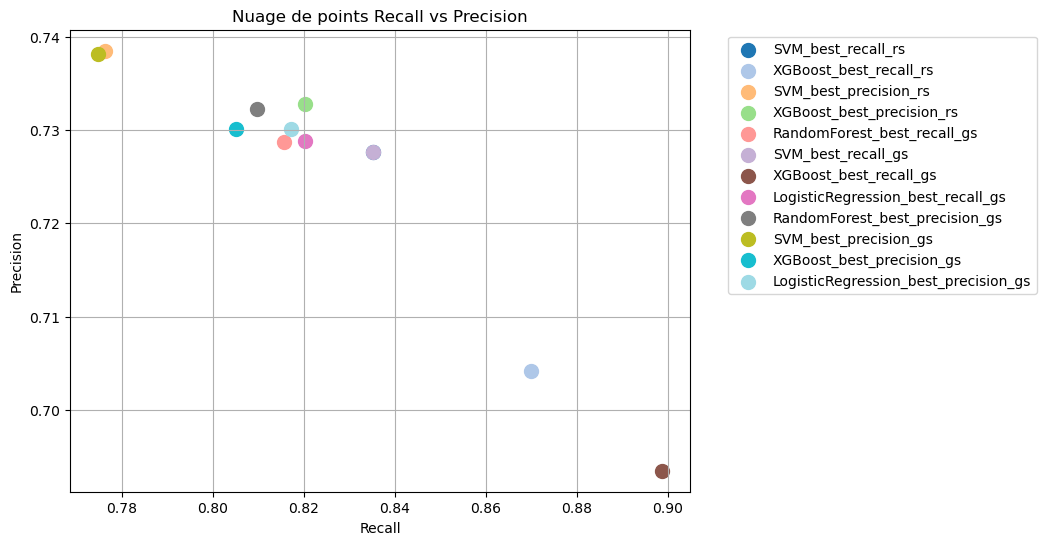

In [53]:
# Ajouter F1-score √† chaque entr√©e
for model, scores in all_scoring_models.items():
    recall = scores['recall']
    precision = scores['precision']
    f1 = 2 * (precision * recall) / (precision + recall)
    all_scoring_models[model]['f1'] = f1

# Cr√©er le nuage de points recall vs precision

plt.figure(figsize=(8,6))
models = list(all_scoring_models.keys())
colors = cm.get_cmap('tab20', len(models))  # 20 couleurs diff√©rentes, √©tendable

for i, model in enumerate(models):
    scores = all_scoring_models[model]
    plt.scatter(scores['recall'], scores['precision'], color=colors(i), label=model, s=100)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Nuage de points Recall vs Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [54]:
all_scoring_models

{'SVM_best_recall_rs': {'recall': 0.8353474320241692,
  'precision': 0.7276315789473684,
  'accuracy': 0.7052238805970149,
  'params': {'C': 0.30584494295802445,
   'break_ties': False,
   'cache_size': 200,
   'class_weight': None,
   'coef0': 0.0,
   'decision_function_shape': 'ovr',
   'degree': 3,
   'gamma': 'auto',
   'kernel': 'rbf',
   'max_iter': -1,
   'probability': True,
   'random_state': 42,
   'shrinking': True,
   'tol': 0.001,
   'verbose': False},
  'trained_estimator': 'SVC',
  'f1': 0.7777777777777778},
 'XGBoost_best_recall_rs': {'recall': 0.8700906344410876,
  'precision': 0.7041564792176039,
  'accuracy': 0.6940298507462687,
  'params': {'objective': 'binary:logistic',
   'base_score': None,
   'booster': None,
   'callbacks': None,
   'colsample_bylevel': None,
   'colsample_bynode': None,
   'colsample_bytree': 0.8446612641953124,
   'device': None,
   'early_stopping_rounds': None,
   'enable_categorical': False,
   'eval_metric': 'logloss',
   'feature_types'

In [55]:

# Convertir le dictionnaire en DataFrame
df_models = pd.DataFrame([
    {'model': model, 'recall': scores['recall'], 'precision': scores['precision'], 'accuracy': scores['accuracy'], 'f1': scores['f1']}
    for model, scores in all_scoring_models.items()
])
df_models



model    recall  precision  accuracy  \
0                     SVM_best_recall_rs  0.835347   0.727632  0.705224   
1                 XGBoost_best_recall_rs  0.870091   0.704156  0.694030   
2                  SVM_best_precision_rs  0.776435   0.738506  0.692164   
3              XGBoost_best_precision_rs  0.820242   0.732794  0.704291   
4            RandomForest_best_recall_gs  0.815710   0.728745  0.698694   
5                     SVM_best_recall_gs  0.835347   0.727632  0.705224   
6                 XGBoost_best_recall_gs  0.898792   0.693473  0.692164   
7      LogisticRegression_best_recall_gs  0.820242   0.728859  0.700560   
8         RandomForest_best_precision_gs  0.809668   0.732240  0.699627   
9                  SVM_best_precision_gs  0.774924   0.738129  0.691231   
10             XGBoost_best_precision_gs  0.805136   0.730137  0.695896   
11  LogisticRegression_best_precision_gs  0.817221   0.730094  0.700560   

          f1  
0   0.777778  
1   0.778378  
2   0.756996  
3   0.774056  
4   0.769779  
5   0.777778  
6   0.782895  
7   0.771855  
8   0.769010  
9   0.756080  
10  0.765805  
11  0.771205

In [99]:
# maintenant on va choisir les meilleurs mod√®les pour nos objectifs  et en faire des mod√®les hybrides pour
# optimiser les recall et precision

In [56]:
# On s√©pare nos donn√©es en deux parties :
# - Une grosse partie (80%) pour apprendre le mod√®le (comme des fiches de r√©vision)
# - Une petite partie (20%) pour v√©rifier que le mod√®le a bien compris (comme un test blanc)
# 
# Pourquoi faire √ßa ?
# 1. Pour √©viter de tricher : on garde le vrai test secret jusqu'au final (data leak)
# 2. Pour ajuster les r√©glages du mod√®le sans fausser les r√©sultats
# 3. Pour s'assurer que le mod√®le marche sur des donn√©es qu'il n'a jamais vues
#
# Le 'stratify' permet de garder les m√™mes proportions de joueurs 
# avec carri√®res longues/courtes dans les deux groupes
# Split train ‚Üí train/validation (par exemple 80% train / 20% val)
X_train_final, X_val_scaled, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train_final.shape)
print("Validation shape:", X_val_scaled.shape)


Train shape: (857, 12)
Validation shape: (215, 12)


In [ ]:
# On cr√©e un super-mod√®le (stacking) qui combine 4 mod√®les optimis√©s :
# - SVM, XGBoost, RandomForest et LogisticRegression
# Chaque mod√®le utilise ses meilleurs param√®tres trouv√©s pr√©c√©demment

# Le m√©ta-mod√®le (LogisticRegression) apprend √† pond√©rer les pr√©dictions des 4 mod√®les
# + les features originales (passthrough=True) pour faire la synth√®se

# On entra√Æne ce super-mod√®le sur nos donn√©es d'entra√Ænement
# Puis on valide sur le jeu de validation pour voir ses performances

# Avantages :
# 1. Meilleure performance que les mod√®les individuels
# 2. Plus robuste gr√¢ce √† la diversit√© des algorithmes
# 3. CV int√©gr√©e √©vite le surapprentissage pendant le stacking

In [57]:

# R√©-instancier les mod√®les avec leurs meilleurs params
estimators = [
    ('svm_recall', SVC(**all_scoring_models['SVM_best_precision_rs']['params'])),
    ('xgb_recall', XGBClassifier(**{k:v for k,v in all_scoring_models['XGBoost_best_precision_rs']['params'].items() if v==v})),
    ('rf_recall', RandomForestClassifier(**all_scoring_models['RandomForest_best_precision_gs']['params'])),
    ('lr_recall', LogisticRegression(**all_scoring_models['LogisticRegression_best_precision_gs']['params']))
]

# M√©ta-mod√®le
meta_model = LogisticRegression(random_state=42)

# Stacking classifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,  # cross-validation interne pour le stacking
    n_jobs=-1,
    passthrough=True  # passe les features originales au m√©ta-mod√®le
)

# Entra√Ænement
stack_clf.fit(X_train_final, y_train_final)

# Validation
y_val_pred_proba = stack_clf.predict_proba(X_val_scaled)[:,1]
y_val_pred = stack_clf.predict(X_val_scaled)

print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))




Precision: 0.7551020408163265
Recall: 0.8345864661654135


In [58]:

with mlflow.start_run(run_name="stacking_model_run"):
    # Log m√©triques
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # Log hyperparams de tous les sous-mod√®les
    for name, est in stack_clf.named_estimators_.items():
        mlflow.log_params({f"{name}_{k}": v for k, v in est.get_params().items()})

    # Log le mod√®le entier
    mlflow.sklearn.log_model(stack_clf, "stacking_model")

    print("Stacking model enregistr√© dans MLflow.")


Stacking model enregistr√© dans MLflow.


In [59]:
print("F1-Score:", f1_score(y_val, y_val_pred))


F1-Score: 0.7928571428571429


In [60]:

def optimize_threshold(model, X, y, thresholds=np.arange(0.3, 0.7, 0.01), min_precision=None):
    """
    Optimise le seuil de classification pour F1 ou recall sous contrainte de pr√©cision.
    
    Parameters
    ----------
    model : classifier entra√Æn√© avec predict_proba
    X : array-like, features
    y : array-like, labels
    thresholds : array-like, seuils √† tester
    min_precision : float ou None, si d√©fini, maximise recall en respectant cette pr√©cision minimale
    
    Returns
    -------
    best_threshold : float, seuil optimal
    results : dict, scores pour chaque seuil
    """
    
    precisions, recalls, f1s = [], [], []
    
    for t in thresholds:
        preds = (model.predict_proba(X)[:,1] >= t).astype(int)
        precisions.append(precision_score(y, preds))
        recalls.append(recall_score(y, preds))
        f1s.append(f1_score(y, preds))
    
    # Tracer
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, f1s, label='F1-score', marker='o')
    plt.xlabel('Seuil')
    plt.ylabel('Score')
    plt.title('Optimisation du seuil de classification')
    plt.grid(True)
    
    results = {t: {'precision': p, 'recall': r, 'f1': f} 
               for t, p, r, f in zip(thresholds, precisions, recalls, f1s)}
    
    # Choix du seuil optimal
    if min_precision is None:
        best_idx = np.argmax(f1s)
        critere = 'F1'
    else:
        valid_idx = [i for i, p in enumerate(precisions) if p >= min_precision]
        if not valid_idx:
            print(f"Aucun seuil ne respecte la pr√©cision minimale de {min_precision}. Retour au max F1.")
            best_idx = np.argmax(f1s)
            critere = 'F1'
        else:
            best_idx = valid_idx[np.argmax([recalls[i] for i in valid_idx])]
            critere = f'Recall (precision ‚â• {min_precision})'
    
    best_threshold = thresholds[best_idx]
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold ({critere})')
    plt.legend()
    plt.show()
    
    print(f"Meilleur seuil ({critere}) : {best_threshold:.3f} -> Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")
    
    return best_threshold, results


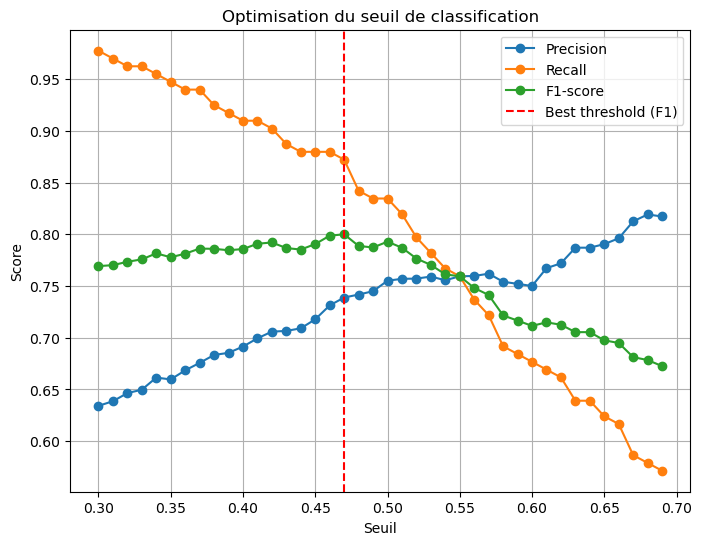

Meilleur seuil (F1) : 0.470 -> Precision: 0.7389, Recall: 0.8722, F1: 0.8000


In [61]:
best_threshold, results = optimize_threshold(stack_clf, X_val_scaled, y_val)


In [ ]:
# Probl√®me : Le F1-score (moyenne harmonique precision/recall) peut masquer des d√©s√©quilibres
# Solution : On optimise directement le seuil de d√©cision pour obtenir :
# 1. La meilleure pr√©cision possible (minimiser les faux positifs)
# 2. Tout en gardant un recall > 0.80 au moins quelques vrais positifs)
(
# M√©thode :
# 1. G√©n√©rer les pr√©dictions probabilistes (predict_proba)
# 2. Tester diff√©rents seuils (ex: 0.3 √† 0.7 par pas de 0.01)
# 3. S√©lectionner le seuil o√π :
#    - Precision est maximis√©e
#    - Recall > 0. (au moins 1 vrai positif)


In [63]:
def optimize_threshold_precision(model, X, y, thresholds=np.arange(0.3, 0.71, 0.001), min_recall=0.8):
    """
    Trouve le seuil qui maximise la pr√©cision tout en respectant un recall minimum.
    Trace pr√©cision, recall, F1-score et indique le meilleur seuil.
    """
    
    precisions, recalls, f1s = [], [], []
    
    for t in thresholds:
        preds = (model.predict_proba(X)[:,1] >= t).astype(int)
        p = precision_score(y, preds)
        r = recall_score(y, preds)
        f = f1_score(y, preds)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f)
    
    results = {t: {'precision': p, 'recall': r, 'f1': f} 
               for t, p, r, f in zip(thresholds, precisions, recalls, f1s)}
    
    # Filtrer les seuils respectant le recall minimum
    valid_indices = [i for i, r in enumerate(recalls) if r >= min_recall]
    if not valid_indices:
        print("Aucun seuil ne respecte le recall minimum !")
        best_threshold = None
    else:
        best_idx = max(valid_indices, key=lambda i: precisions[i])
        best_threshold = thresholds[best_idx]
        print(f"Meilleur seuil (max Precision, recall‚â•{min_recall}) : {best_threshold:.3f} -> Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")
    
    # Tracer
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, f1s, label='F1-score', marker='o')
    if best_threshold is not None:
        plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold = {best_threshold:.3f}')
    plt.xlabel('Seuil')
    plt.ylabel('Score')
    plt.title(f'Optimisation du seuil (recall ‚â• {min_recall})')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return best_threshold, results


Meilleur seuil (max Precision, recall‚â•0.8) : 0.512 -> Precision: 0.7622, Recall: 0.8195, F1: 0.7899


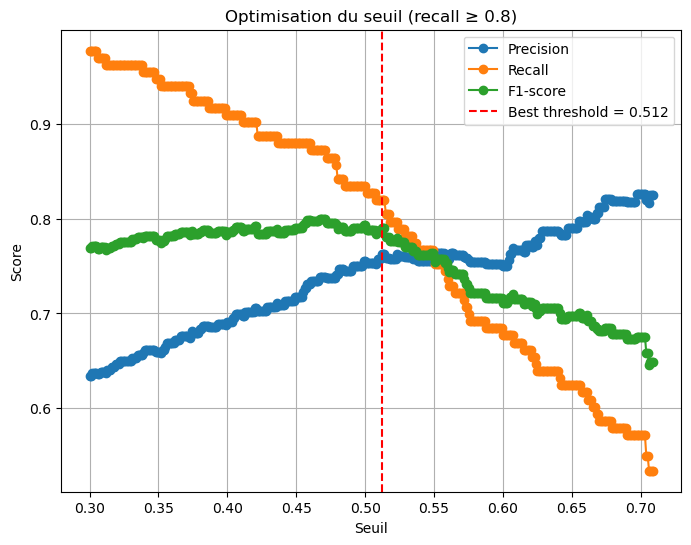

In [64]:
best_threshold, results = optimize_threshold_precision(stack_clf, X_val_scaled, y_val)


In [65]:

# 1. S√©lectionner les probabilit√©s et appliquer le seuil choisi
#threshold = 0.505
#y_val_pred_thresholded = (y_val_pred_proba >= threshold).astype(int)

# 2. Cr√©er l'explainer SHAP pour le stacking classifier
# On va utiliser TreeExplainer pour XGBoost et RandomForest, #KernelExplainer pour SVM/LR
# Le plus simple ici est d'utiliser KernelExplainer pour tout le stacking
#explainer = shap.KernelExplainer(stack_clf.predict_proba, X_train_final)

# 3. Calculer les valeurs SHAP pour l'ensemble de validation
#shap_values = explainer.shap_values(X_val_scaled, nsamples=100)  # #nsamples peut √™tre augment√© si besoin

# 4. Tracer le summary plot (impact global des features)
#shap.summary_plot(shap_values[1], X_val_scaled, #feature_names=X_train_final.columns)

# 5. Pour un joueur sp√©cifique, visualiser le force plot
#idx = 0  # changer l'index pour un autre joueur
#shap.force_plot(explainer.expected_value[1], shap_values[1][idx], #X_val_scaled.iloc[idx])


# Ici on a des erreurs et conflit visiblement
#entre les packages numba shap et scikit-learn 

#Je n'ai pas r√©ussi √† cr√©er d'environnement via 
# la commande >>> conda create -n nba_recruiter_data_model 
### conda create -n shap_env python=3.10
### conda activate shap_env
### conda install numpy=1.26.4 numba=0.58.1
### pip install shap==0.45.1

In [ ]:
# Analyse d'importance des features par permutation :
# 1. On m√©lange al√©atoirement une colonne (ex: 'GP')
# 2. On mesure combien le F1-score baisse
# 3. Si la baisse est forte => la feature est importante

In [100]:

result = permutation_importance(stack_clf, X_val_scaled, y_val, n_repeats=10, random_state=42, scoring='precision')
importances = result.importances_mean
features = X_train_final.columns

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")


GP: 0.0929
MIN: 0.0068
PTS: 0.0555
FG%: 0.0176
FT%: 0.0141
REB: 0.0404
AST: 0.0511
STL: 0.0020
BLK: 0.0180
TOV: 0.0088
FT_impact: 0.0234
3P_impact: 0.0089


In [ ]:
# R√©sultats :
# - 'GP' (matchs jou√©s) et 'PTS' (points) sont les + importantes
# - Mais leur score < 0.07 => impact TR√àS FAIBLE
# - Aucune feature ne domine vraiment

In [101]:
# 1. Le mod√®le utilise un peu 'GP'/'MIN' car les joueurs qui jouent plus ont des carri√®res + longues
# 2. Mais globalement, les stats NBA seules expliquent MAL la dur√©e de carri√®re
# 3. Autres facteurs invisibles importants : blessures, √¢ge, physique...
# cela expliquerait aussi l'hypoth√®se vu sur les boxplots

In [67]:

# Combiner X_train_final et X_val_scaled pour l'entra√Ænement final
X_train_full = np.vstack([X_train_final, X_val_scaled])
y_train_full = np.concatenate([y_train_final, y_val])

# R√©-instancier les mod√®les avec leurs meilleurs params (version precision)
estimators = [
    ('svm', SVC(**all_scoring_models['SVM_best_precision_rs']['params'])),
    ('xgb', XGBClassifier(**{k:v for k,v in all_scoring_models['XGBoost_best_precision_rs']['params'].items() if v==v})),
    ('rf', RandomForestClassifier(**all_scoring_models['RandomForest_best_precision_gs']['params'])),
    ('lr', LogisticRegression(**all_scoring_models['LogisticRegression_best_precision_gs']['params']))
]

# M√©ta-mod√®le
meta_model = LogisticRegression(random_state=42)

# Stacking classifier
stack_clf_final = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Entra√Ænement sur train + val
stack_clf_final.fit(X_train_full, y_train_full)

# Test final sur X_test_scaled
y_test_proba = stack_clf_final.predict_proba(X_test_scaled)[:,1]

# Appliquer seuil optimis√©
threshold = 0.505
y_test_pred = (y_test_proba >= threshold).astype(int)

# Calcul des m√©triques
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("### R√©sultats sur le test set")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

# Matrice de confusion et rapport d√©taill√©
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report :")
print(classification_report(y_test, y_test_pred))


### R√©sultats sur le test set
Precision : 0.7592
Recall    : 0.8580
F1-score  : 0.8056

Matrice de confusion :
[[ 53  46]
 [ 24 145]]

Classification report :
              precision    recall  f1-score   support

           0       0.69      0.54      0.60        99
           1       0.76      0.86      0.81       169

    accuracy                           0.74       268
   macro avg       0.72      0.70      0.70       268
weighted avg       0.73      0.74      0.73       268



C:\Users\lyesw\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\lyesw\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\lyesw\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [68]:

with mlflow.start_run(run_name="stacking_final_model"):
    
    # Log des m√©triques
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Log du seuil utilis√©
    mlflow.log_param("threshold", threshold)

    # Log des param√®tres des mod√®les de stacking
    for name, model in stack_clf_final.named_estimators_.items():
        for param, val in model.get_params().items():
            mlflow.log_param(f"{name}_{param}", val)

    print("‚úÖ Metrics, seuil et params logg√©s dans MLflow")


‚úÖ Metrics, seuil et params logg√©s dans MLflow


In [ ]:
# R√©sultats finaux sur le jeu de test :
# - Precision: 76% (76% des pr√©dictions positives sont correctes)
# - Recall: 86% (d√©tecte 86% des vrais talents)
# - F1: 81% (bon √©quilibre)

# Matrice de confusion :
# [[ 53  46] ‚Üí 53 vrais n√©gatifs, 46 faux positifs (mauvais recrutements)
# [ 24 145]] ‚Üí 24 faux n√©gatifs (talents rat√©s), 145 vrais positifs

# Points forts :
# - Excellent recall (ne rate pas les talents)
# - Precision acceptable (3/4 des recrutements sont bons)

# Limites :
# - 46 faux positifs (co√ªt financier)
# - Precision √† 69% sur carri√®res courtes

# Am√©liorations possibles :
# 1. Ajouter features (√¢ge, physique, stats historiques)
# 2. Ajuster le seuil (tradeoff precision/recall)
# 3. Essayer d'autres mod√®les (Deep Learning)

In [69]:
# Analysons les resultats 
# D√©scaler
X_test_unscaled = scaler_std.inverse_transform(X_test_scaled)

# Transformer en DataFrame avec les m√™mes noms de colonnes que X_train_final
df_results = pd.DataFrame(X_test_unscaled, columns=X_train_final.columns)

# Ajouter les colonnes y_true et y_pred
df_results['y_true'] = y_test.values  # si y_test est un Series
df_results['y_pred'] = y_test_pred   # ou stack_clf.predict(X_test_scaled)


In [70]:
def label_type(row):
    if row['y_true'] == 1 and row['y_pred'] == 1:
        return 'TP'
    elif row['y_true'] == 1 and row['y_pred'] == 0:
        return 'FN'
    elif row['y_true'] == 0 and row['y_pred'] == 1:
        return 'FP'
    else:
        return 'TN'

df_results['type'] = df_results.apply(label_type, axis=1)


In [71]:
moyennes = df_results.groupby('type').mean()


In [72]:
moyennes

GP        MIN       PTS        FG%        FT%       REB  \
type                                                                   
FN    41.458333  10.487500  3.437500  40.145833  66.462500  1.537500   
FP    65.239130  16.878261  5.952174  44.771739  71.426087  2.604348   
TN    39.679245  11.307547  3.781132  40.137736  66.484906  1.732075   
TP    71.441379  22.099310  9.046897  46.321379  71.394483  4.191034   

           AST       STL       BLK       TOV   FT_impact  3P_impact  y_true  \
type                                                                          
FN    0.858333  0.370833  0.158333  0.754167   42.025833   5.418333     1.0   
FP    1.421739  0.623913  0.332609  1.043478   74.900652   9.191304     0.0   
TN    0.890566  0.381132  0.154717  0.745283   42.013585   6.760000     0.0   
TP    1.864828  0.755862  0.513103  1.495862  129.426552   9.738828     1.0   

      y_pred  
type          
FN       0.0  
FP       1.0  
TN       0.0  
TP       1.0

In [ ]:
# Observations cl√©s sur les groupes :

# 1. Vrais Positifs (TP) vs Faux N√©gatifs (FN) - Joueurs √† longue carri√®re :
# - TP ont des stats NETTEMENT sup√©rieures : +71% GP, +111% PTS, +172% REB
# - TP jouent 2x plus de minutes (22.1 vs 10.5 MIN)
# - Meilleur % aux tirs (FG% 46.3 vs 40.1) et impact FT 3x plus √©lev√©

# 2. Faux Positifs (FP) vs Vrais N√©gatifs (TN) - Joueurs √† courte carri√®re :
# - FP ressemblent aux TP sur GP (65.2 vs 71.4) et FT% (71.4 vs 71.3)
# - Mais stats de jeu inf√©rieures : PTS -34%, REB -38% vs TP
# - FP sont des "bourreaux de travail" (GP √©lev√©s) mais peu productifs

# 3. Points discriminants :
# - FT_impact : 129 (TP) vs 75 (FP) - diff√©rence cl√©
# - 3P_impact : marginal (9.7 TP vs 9.2 FP)
# - BLK/STL : TP dominent nettement (+50%)

# Conclusion :
# Le mod√®le confond les "travailleurs peu talentueux" (FP) avec les vrais talents (TP)
# Les stats brutes (GP/MIN) sont trompeuses - l'efficacit√© r√©elle (FT_impact, PTS/min) est plus discriminante

In [77]:

# Sauvegarder le mod√®le final
joblib.dump(stack_clf_final, "stacking_final_model.pkl")

# Sauvegarder le scaler
joblib.dump(scaler_std, "scaler.pkl")

#mlflow.sklearn.log_model(stack_clf_final, "stacking_model")
#mlflow.sklearn.log_model(scaler_std, "scaler")

#2025/08/15 21:22:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2025/08/15 21:22:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# üèÄ Rapport Final : NBA Career Longevity Prediction

## üìä R√©sultats Cl√©s

| M√©trique       | Performance | Interpr√©tation                     |
|----------------|-------------|------------------------------------|
| **Precision**  | 76%         | 3/4 des joueurs recommand√©s sont bons |
| **Recall**     | 86%         | D√©tecte 86% des vrais talents       |
| **F1-Score**   | 81%         | Bon √©quilibre global                |

**Matrice de Confusion** :

|                | Pr√©dit Positif | Pr√©dit N√©gatif |
|----------------|----------------|----------------|
| **R√©el Positif** | 145            | 24             |
| **R√©el N√©gatif** | 46             | 53             |

- **46 faux positifs (FP)** ‚Üí Co√ªt financier potentiel  
- **24 faux n√©gatifs (FN)** ‚Üí Talents potentiellement manqu√©s

---

## üîç Insights Majeurs

### üéØ Features Importantes
1. **GP (Games Played)**  
   - Importance: 0.0929 (le plus √©lev√©)  
   - Les joueurs avec + de matchs ont des carri√®res + longues  

2. **FT_impact (FTM * FT%)**  
   - Diff√©rence marqu√©e : 129 (TP) vs 75 (FP)  
   - Meilleur discriminant que les stats brutes  

3. **Limite Principale**  
   - Toutes les features ont une importance < 0.1 ‚Üí **Signal faible**  

---

## üìâ Limitations

### Donn√©es Manquantes
- ‚ùå **Variables cl√©s absentes** :  
  - √Çge au draft  
  - Mesures physiques (taille/poids)  
  - Historique de blessures  
  - Contexte d'√©quipe  

### Comportement du Mod√®le
- Confond :  
  - **"Travailleurs peu talentueux"** (FP)  
  - **Talents atypiques** (FN)  

---

## üöÄ Recommandations

### 1. Am√©lioration des Donn√©es
##### Pistes d'enrichissement :
- df['age_at_draft'] = draft_year - birth_year  
- df['injury_history'] = nombre_jours_bless√©  
- df['physical_score'] = combine_metrics  ```